In [2]:
import sys, os
sys.path.append('../Interpreters')
import lime
from lime import lime_image
import numpy as np
import glob as gb
import cv2
import matplotlib.pyplot as plt
sys.path.append('../Biteam/src/utils')
import preprocessor as preprocess
import keras
from keras.models import load_model
print('Notebook run using keras:', keras.__version__)
from sklearn.metrics import confusion_matrix


%matplotlib inline

Using TensorFlow backend.


Notebook run using keras: 2.0.5


# Configuration and Display #

In [2]:
emotion_labels = {0:'angry',1:'disgust',2:'fear',3:'happy', 4:'sad',5:'surprise',6:'neutral'} 
wanted = 6       # want to check this emotion
n_samples = 30   # number of samples to display

# Load trained model #

In [3]:
# name-batch-accuracy
emotion_model_path = '../Biteam/trained_models/emotion_models/fer2013_mini_XCEPTION.hdf5'
emotion_classifier = load_model(emotion_model_path, compile=False)

# Get model configuration #

In [4]:
emotion_target_size = emotion_classifier.input_shape[1:3]
print(emotion_target_size)

(64, 64)


# Read images for testing #

In [5]:
acc_pred = []
y_softmax = []
y_pred = []
y_true = []
y_file = []
folder = '../Dataset/Kaggle/fer2013/PrivateTest/'
for i in range(len(emotion_labels)):
    # read file in each emotion folder 
    filepath  = os.path.join(folder,str(i),'*.jpg')
    filenames = gb.glob(filepath)
    N_test = len(filenames)
    # making a prediction for this emotion i
    hit = 0
    for img_file in filenames: 
        
        # read data and normalised it as trained
        img = preprocess._imread(img_file)
        img = preprocess._imresize(img,emotion_target_size)
        img = preprocess.preprocess_input(img)
        # 4D reshape tensor
        img_data = np.expand_dims(img, 0)
        img_data = np.expand_dims(img_data, -1)
        # prediction
        preds = emotion_classifier.predict(img_data) 
        # decode to a predicted label
        emotion_pred = np.argmax(preds)
        emotion_true = i
        
        if (emotion_pred == emotion_true):
            hit +=1
        
        # record data: prediction and softmax     
        y_pred.append(emotion_pred)
        y_true.append(emotion_true)
        y_softmax.append(preds[0])
        y_file.append(img_file)
   
    # compute accuracy
    accuracy = hit/N_test        
    print('Class accuracy: {a:s} = {b:0.4f}'.format( a=emotion_labels[emotion_true], b=accuracy ) )
    acc_pred.append(accuracy)

# mean accuracy for all images
print('Mean accuracy for prediction = ', np.mean(acc_pred))

Class accuracy: angry = 0.5621
Class accuracy: disgust = 0.5455
Class accuracy: fear = 0.4053
Class accuracy: happy = 0.8840
Class accuracy: sad = 0.5354
Class accuracy: surprise = 0.7380
Class accuracy: neutral = 0.7045
Mean accuracy for prediction =  0.624948842062


# Build 4D image data #

In [6]:
def Build_Data(image, target_size):
    # build data for the train model (resize and normalise scale) 
    img = preprocess._imresize(image,target_size)
    img = preprocess.preprocess_input(img)
    # 4D reshape tensor
    img_data = np.expand_dims(img, 0)
    img_data = np.expand_dims(img_data, -1)
    # make 3 channels data for lime- make 3 channel data
    image_stack = np.append(img_data, img_data[...,0,None], axis=-1)
    image_stack = np.append(image_stack, img_data[...,0,None], axis=-1)
    image_stack = image_stack.astype('float32')
    image_stack = np.asarray(image_stack)
    return image_stack
    

In [7]:
from skimage.segmentation import mark_boundaries

In [ ]:
                #                     RIGHT/WRONG ANALYSIS FROM A CONFUSION MATRIX              #
                # ----------------------------------------------------------------------------- #  
                #  - Case 5: Right prediction                                                   #
                #  - Case 6: Wrong prediction (the highest wrong prediction label)              #
                #------------------------------------------------------------------------------ #   

In [8]:
cf_matrix = confusion_matrix(y_true, y_pred)
print(emotion_labels)
print("----------- Prediction ----------------")
print(cf_matrix)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
----------- Prediction ----------------
[[276   8  48  20  71   9  59]
 [ 13  30   5   2   2   0   3]
 [ 60   5 214  19 113  60  57]
 [  9   1  15 777  33  17  27]
 [ 55   1  53  30 318   7 130]
 [ 13   1  49  25  10 307  11]
 [ 26   1  29  35  84  10 441]]


In [9]:
# find the worst of the wrong predicition
cf_sort = np.argsort(cf_matrix[wanted,:])    #min to max
wrong_pred_idx = cf_sort[-2]
print("worst wrong indx: ", wrong_pred_idx)

worst wrong indx:  4


In [10]:
case5_list = [] #right prediction 
case6_list = [] #wrong prediciton on the worst case class
for i in range(len(y_pred)):
    label_true  = y_true[i]
    # pick this class for the evaluation
    if(label_true == wanted):
        label_pred  = y_pred[i]
        label_sfmax = y_softmax[i]
        # get prediction state: right
        pred_state = (label_pred == label_true)
        if(pred_state):
            case5_list.append(i)
        # get prediction state: wrong
        else:
            # get the worst wrong prediction
            if label_pred == wrong_pred_idx:
                case6_list.append(i)

print("Case5:Right prediction ",len(case5_list))
print("Case6:Wrong prediction ",len(case6_list))

Case5:Right prediction  441
Case6:Wrong prediction  84


In [11]:
image_data = []
max_length = min(len(case5_list), n_samples)
for i in range(max_length):
    f_indx = case5_list[i]
    case_img = preprocess._imread(y_file[f_indx])
    case_data = Build_Data(case_img, emotion_target_size)
    image_data.append(case_data)
    print(y_file[f_indx])
    
right_explanation_out = []
right_segmentation_out = []
explainer = lime_image.LimeImageExplainer(data_channel='gray')
for i in range(max_length):
    lime_input = image_data[i]
    # Hide color is the color for a superpixel turned OFF.
    # Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
    explanation,segments_img = explainer.explain_instance(lime_input[0], emotion_classifier.predict, top_labels=7, \
                                             hide_color=0, num_samples=1000,num_features=500, qs_kernel_size=2)
    
    right_explanation_out.append(explanation)
    right_segmentation_out.append(segments_img)

../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_10551855.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_48487180.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_61038733.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_89953657.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_49413349.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_47874490.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_56742661.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_35354528.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_64798671.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_9299717.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_39715572.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_2057263.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_94259076.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_57870254.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_29880500.jpg
../Dataset/Kaggle/fer2013/P

In [12]:
image_data[1][0].shape

(64, 64, 3)

# LIME Analysis #

In [ ]:
                                   
                                   
                                             ##  RIGHT PREDICTION  ## 
                                   
                                   

Ground truth label: neutral


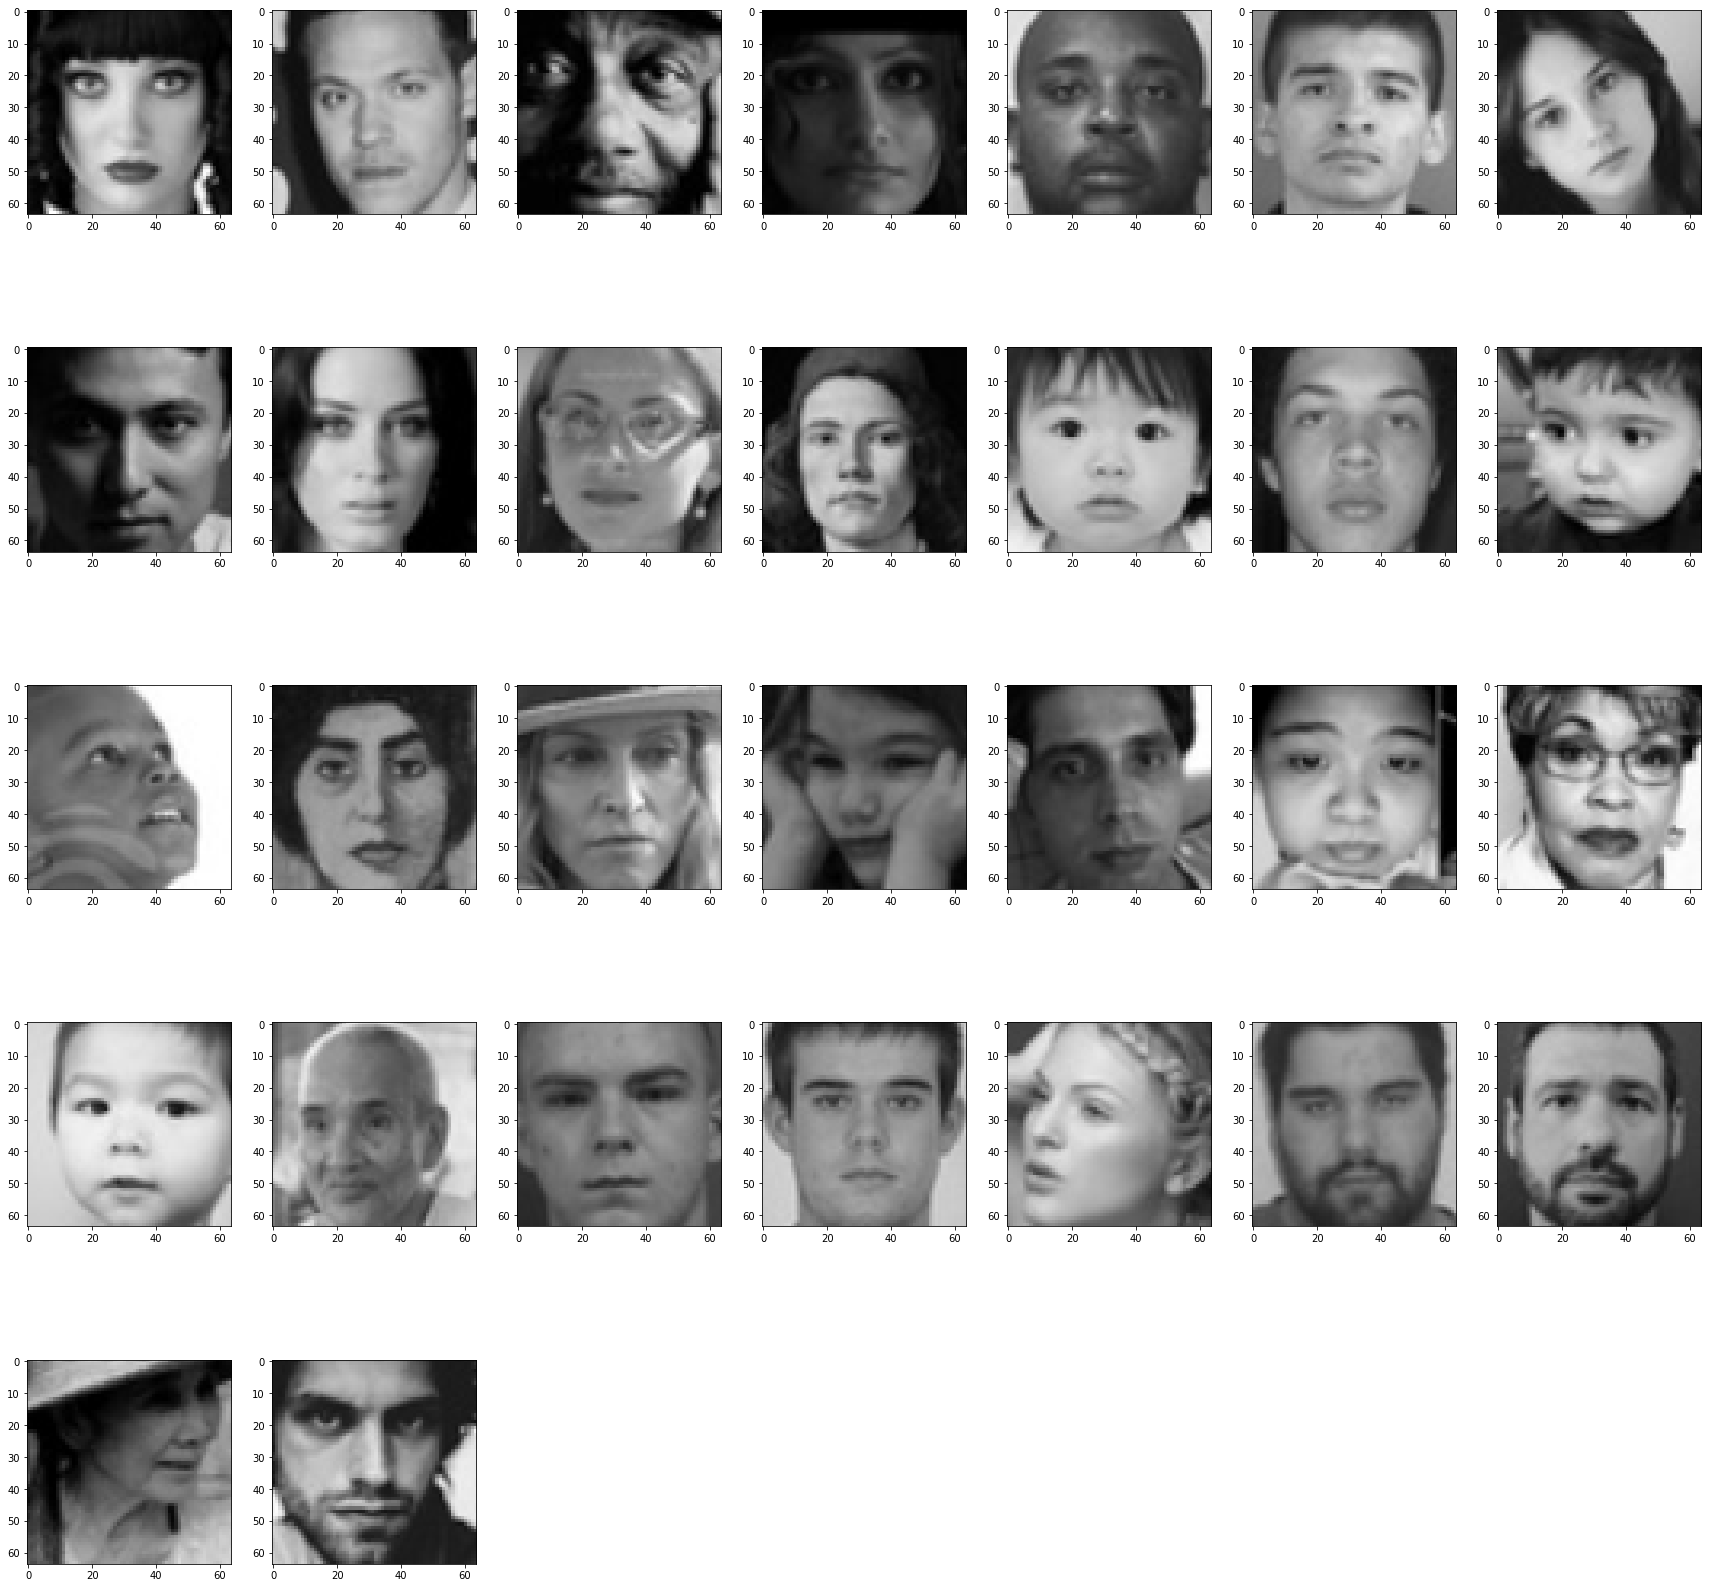

In [13]:
print("Ground truth label: {a:s}".format(a=emotion_labels[wanted]))
plt.figure(figsize=(30,30))
for i in range(max_length):
    img = image_data[i][0]
    plt.subplot(int(max_length/7 + 1),7,i+1)
    plt.imshow(img/2+0.5)

SHOW POSITIVE/NEGATIVE FEATURES IMAGE OVERLAY
Ground truth image: neutral ----> Prediction: neutral


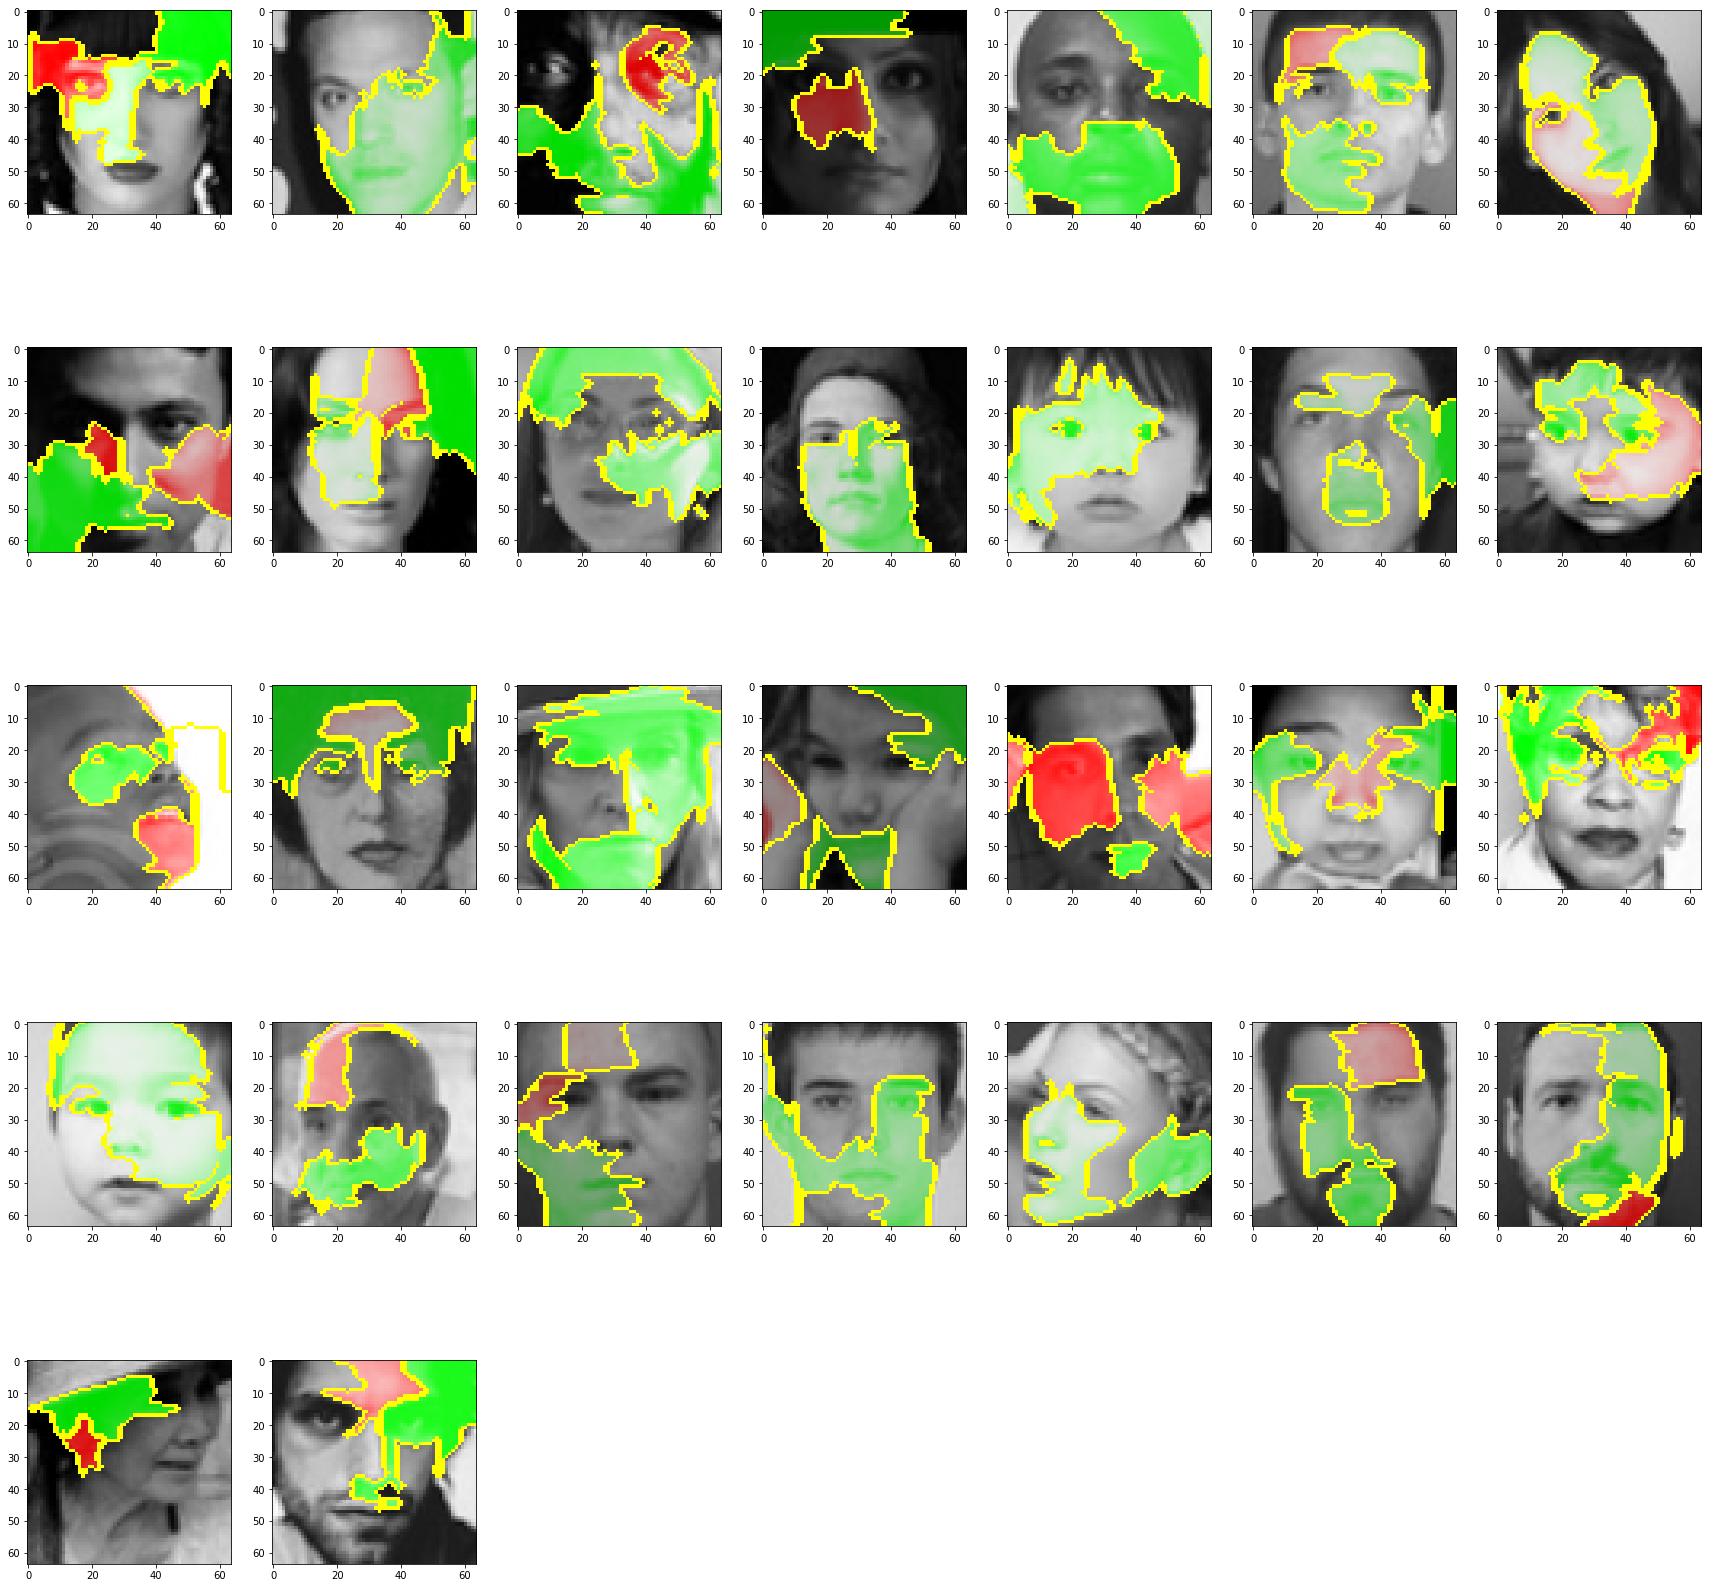

In [14]:
print("SHOW POSITIVE/NEGATIVE FEATURES IMAGE OVERLAY")
print("Ground truth image: {a:s} ----> Prediction: {a:s}".format(a=emotion_labels[wanted]))
plt.figure(figsize=(30,30))
for i in range(max_length):
    explanation = right_explanation_out[i]
    temp, mask = explanation.get_image_and_mask(wanted, positive_only=False, num_features=3, hide_rest=False)
    plt.subplot(int(max_length/7 + 1),7,i+1)
    plt.imshow(mark_boundaries(temp/2+0.5, mask))


ONLY SHOW POSITIVE FEATURES
Ground truth image: neutral ----> Prediction: neutral


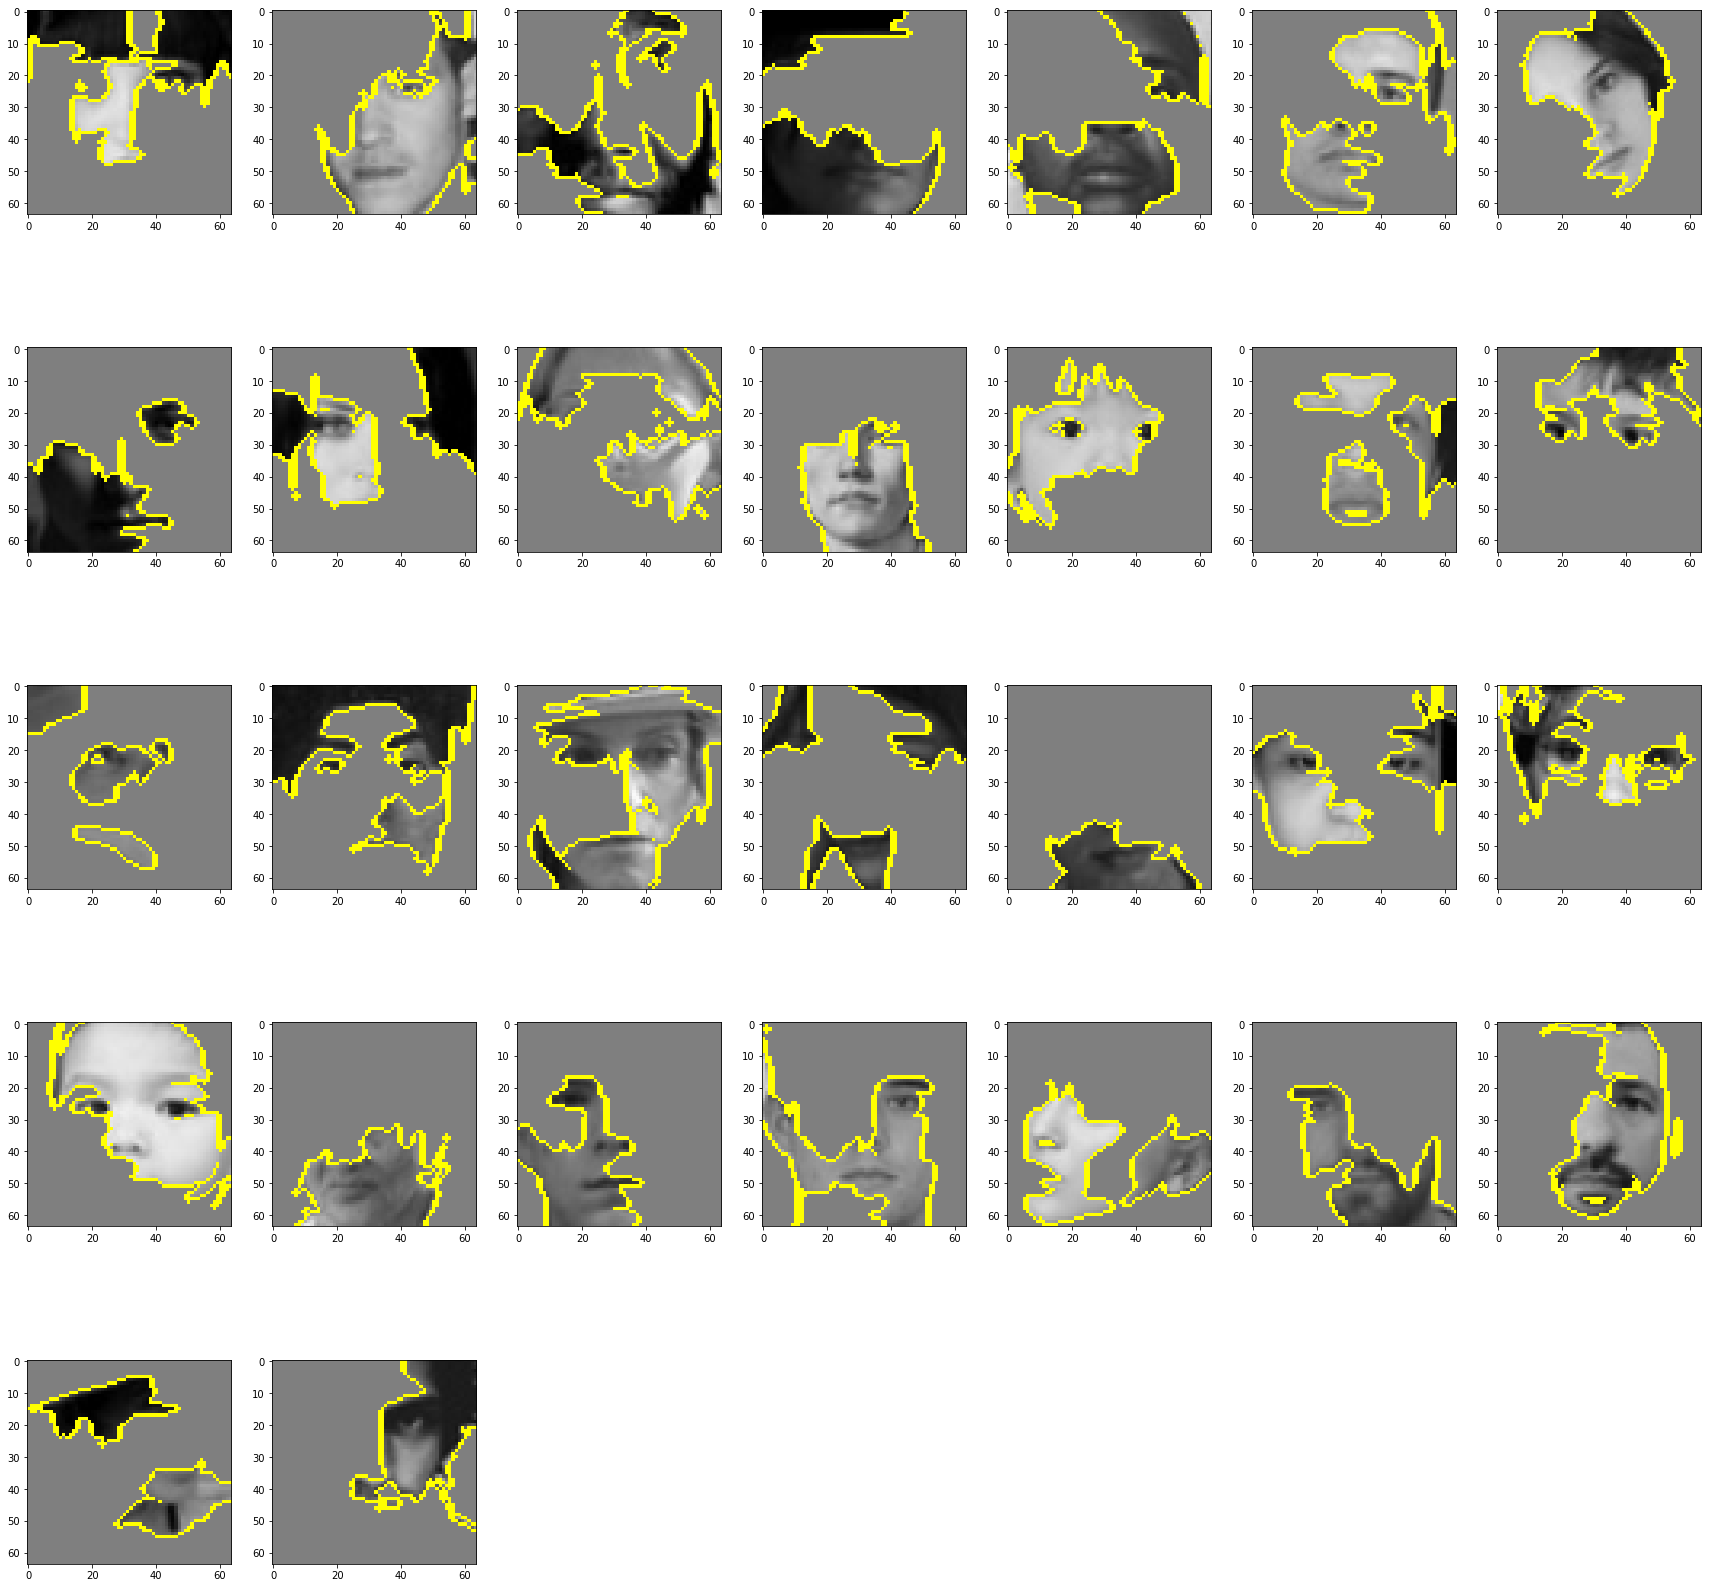

In [15]:
print("ONLY SHOW POSITIVE FEATURES")
print("Ground truth image: {a:s} ----> Prediction: {a:s}".format(a=emotion_labels[wanted]))
plt.figure(figsize=(30,30))
for i in range(max_length):
    explanation = right_explanation_out[i]
    temp, mask = explanation.get_image_and_mask(wanted, positive_only=True, num_features=3, hide_rest=True)
    plt.subplot(int(max_length/7)+1,7,i+1)
    plt.imshow(mark_boundaries(temp/2+0.5, mask))

In [ ]:
                                            
                                            
                                        ##  WRONG PREDICTION  ## 
                                            
                                            

In [16]:
image_data = []
max_length = min(len(case6_list), n_samples)
for i in range(max_length):
    f_indx = case6_list[i]
    case_img = preprocess._imread(y_file[f_indx])
    case_data = Build_Data(case_img, emotion_target_size)
    image_data.append(case_data)
    print(y_file[f_indx])
    
wrong_explanation_out = []
wrong_segmentation_out = []
explainer = lime_image.LimeImageExplainer(data_channel='gray')
for i in range(max_length):
    lime_input = image_data[i]
    # Hide color is the color for a superpixel turned OFF.
    # Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
    explanation,segments_img = explainer.explain_instance(lime_input[0], emotion_classifier.predict, top_labels=7, \
                                             hide_color=0, num_samples=1000,num_features=500, qs_kernel_size=2)
    
    wrong_explanation_out.append(explanation)
    wrong_segmentation_out.append(segments_img)

../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_47149553.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_30840605.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_75748307.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_71889961.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_82957903.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_59558358.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_37227893.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_86635650.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_71048867.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_5789723.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_53851145.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_78270419.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_21208701.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_72609671.jpg
../Dataset/Kaggle/fer2013/PrivateTest/6/PrivateTest_54686764.jpg
../Dataset/Kaggle/fer2013/

Ground truth label: neutral


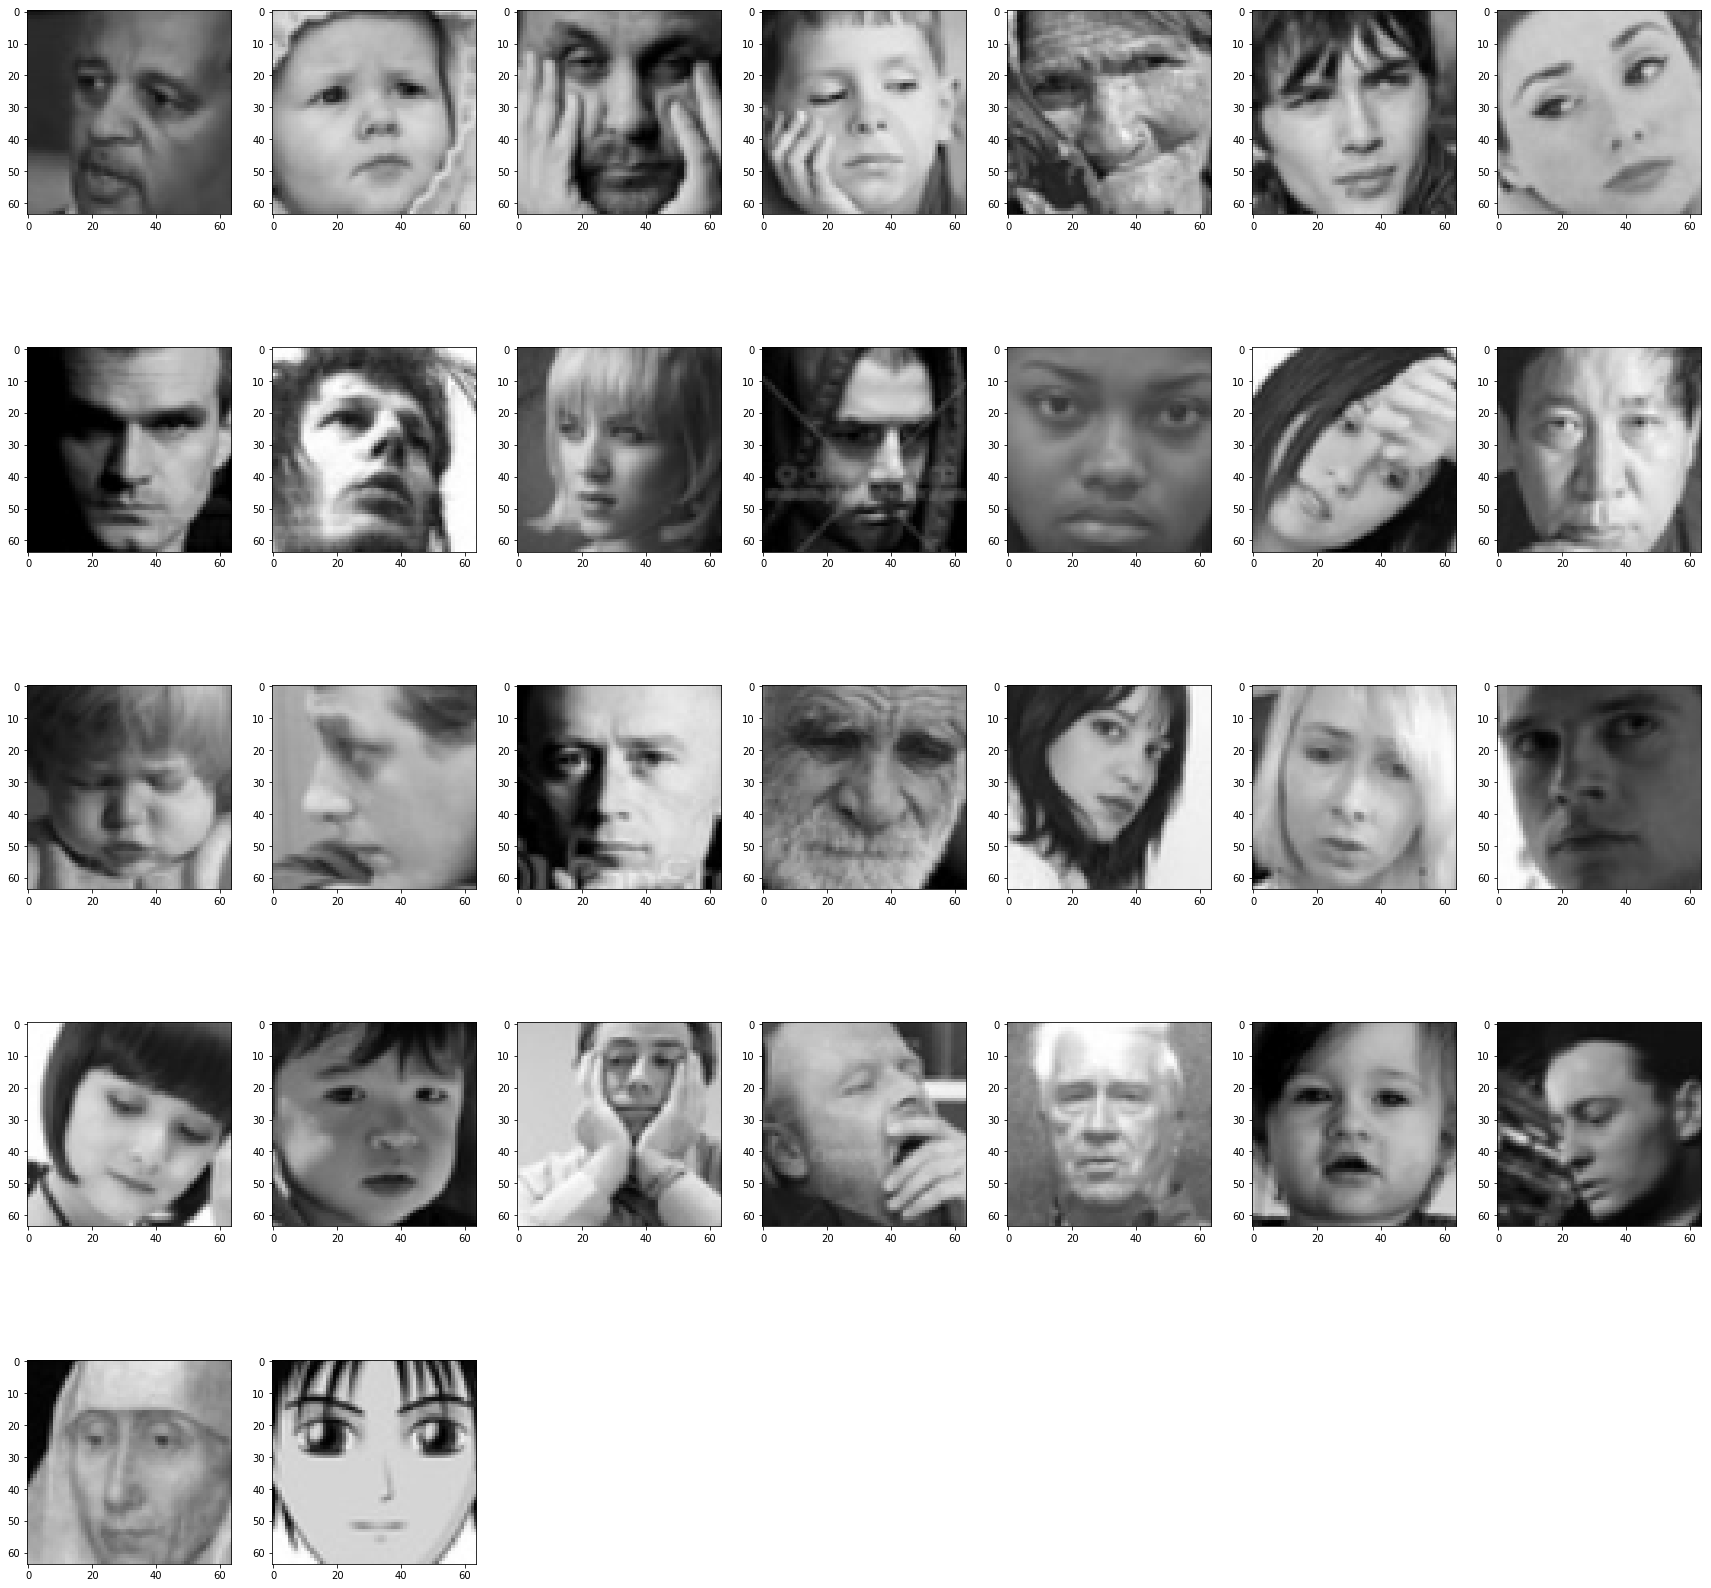

In [17]:
print("Ground truth label: {a:s}".format(a=emotion_labels[wanted]))
plt.figure(figsize=(30,30))
for i in range(max_length):
    img = image_data[i][0]
    plt.subplot(int(max_length/7 + 1),7,i+1)
    plt.imshow(img/2+0.5)

SHOW POSITIVE/NEGATIVE FEATURES IMAGE OVERLAY
Ground truth image: neutral ----> Prediction: sad


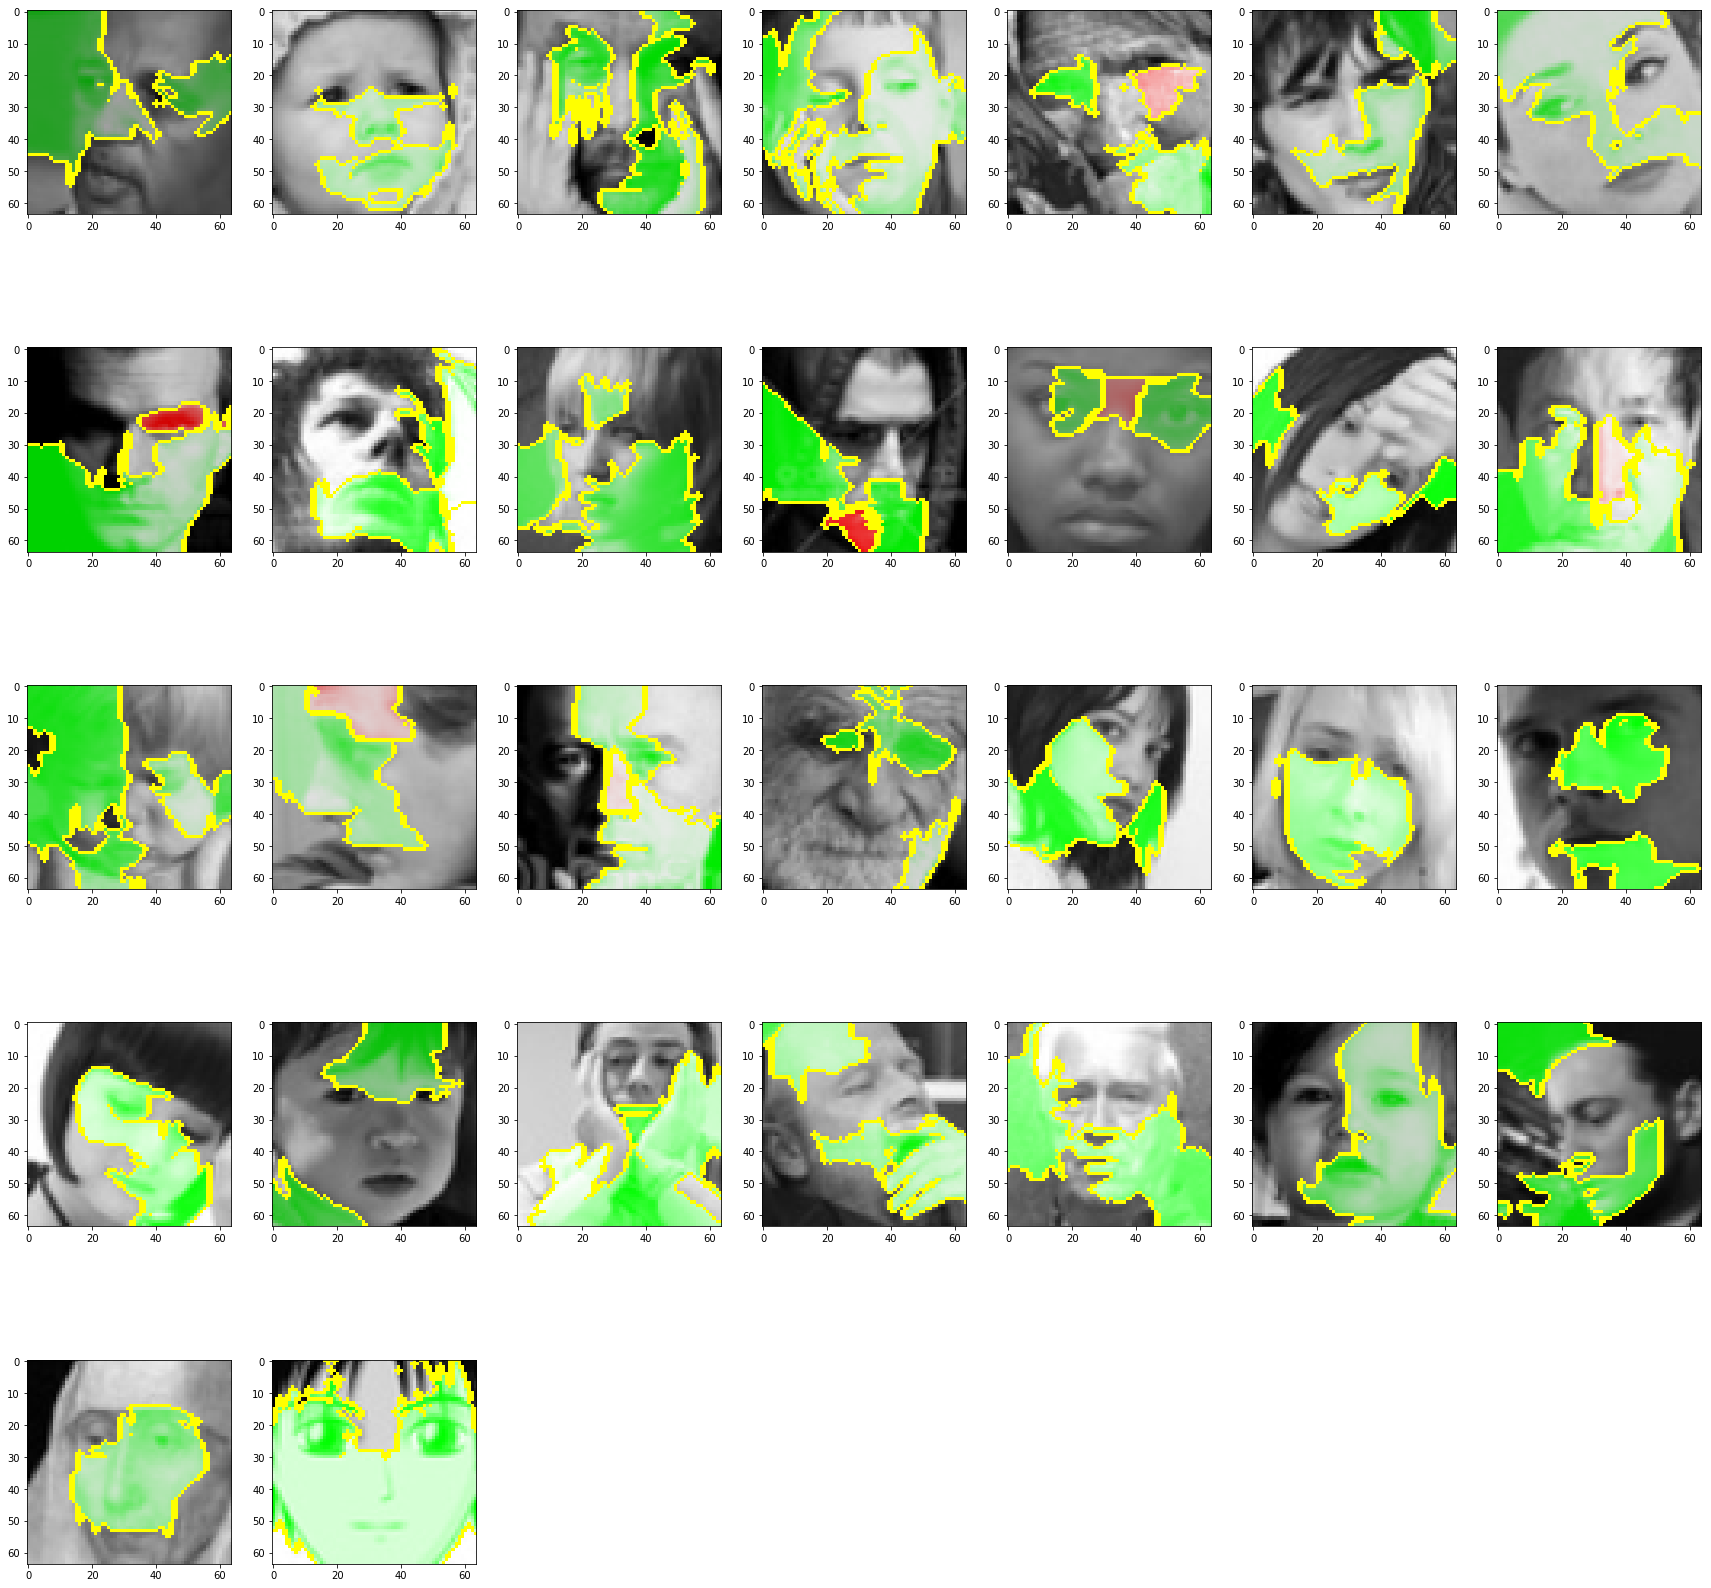

In [18]:
print("SHOW POSITIVE/NEGATIVE FEATURES IMAGE OVERLAY")
print("Ground truth image: {a:s} ----> Prediction: {b:s}".format(a=emotion_labels[wanted],\
                                                                 b=emotion_labels[wrong_pred_idx]))
plt.figure(figsize=(30,30))
for i in range(max_length):
    explanation = wrong_explanation_out[i]
    temp, mask = explanation.get_image_and_mask(wrong_pred_idx, positive_only=False, num_features=3, hide_rest=False)
    plt.subplot(int(max_length/7 +1),7,i+1)
    plt.imshow(mark_boundaries(temp/2+0.5, mask))

ONLY SHOW POSITIVE FEATURES
Ground truth image: neutral ----> Prediction: sad


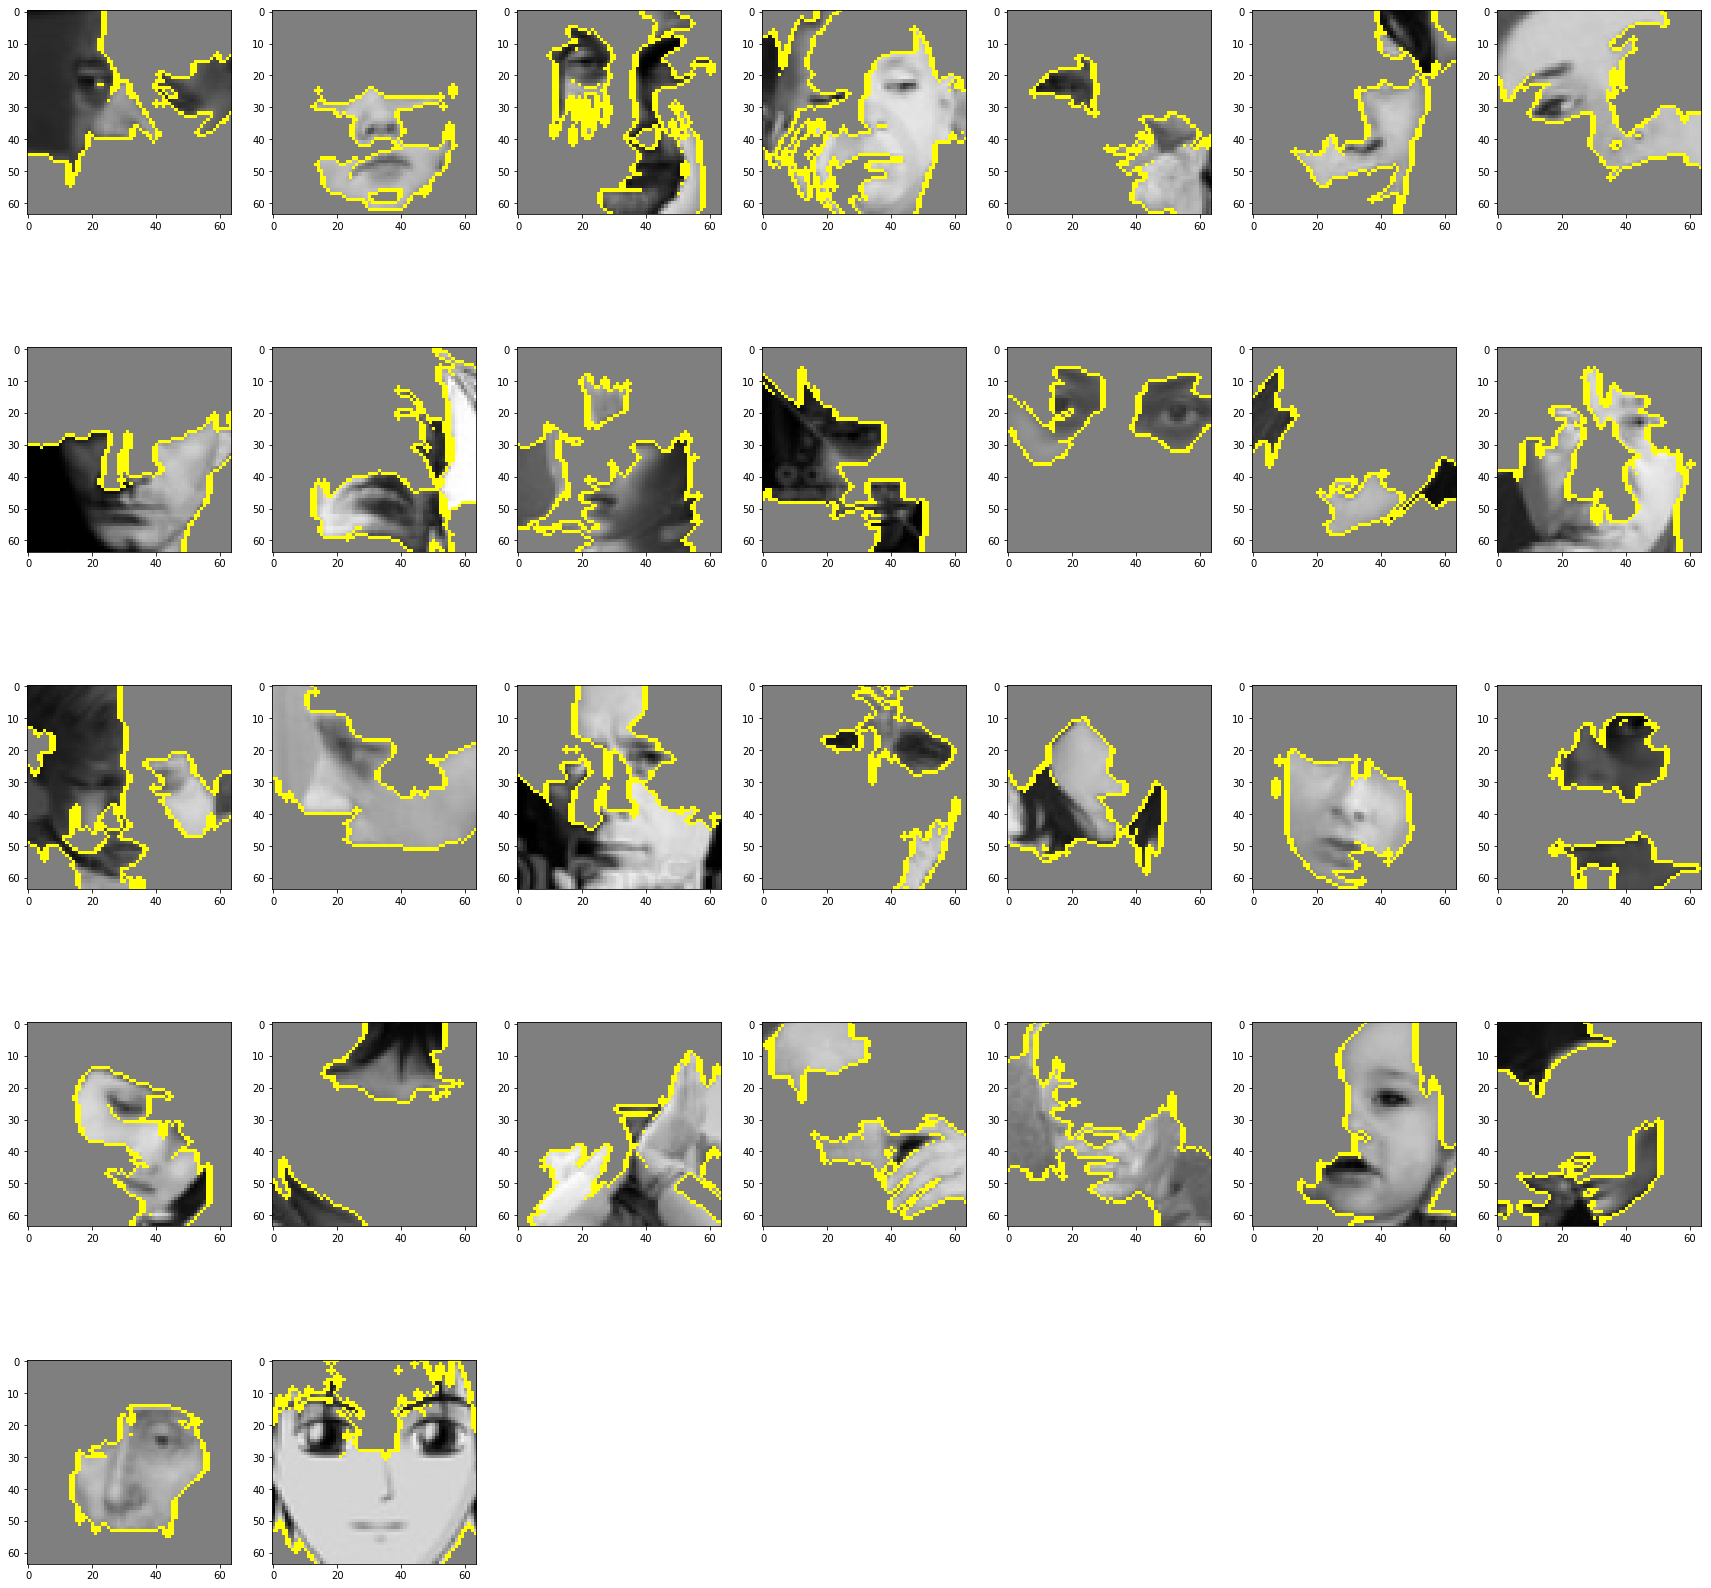

In [19]:
print("ONLY SHOW POSITIVE FEATURES")
print("Ground truth image: {a:s} ----> Prediction: {b:s}".format(a=emotion_labels[wanted],\
                                                                 b=emotion_labels[wrong_pred_idx]))
plt.figure(figsize=(30,30))
for i in range(max_length):
    explanation = wrong_explanation_out[i]
    temp, mask = explanation.get_image_and_mask(wrong_pred_idx, positive_only=True, num_features=3, hide_rest=True)
    plt.subplot(int(max_length/7+1),7,i+1)
    plt.imshow(mark_boundaries(temp/2+0.5, mask))